In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
import json

#TODO:
- izbaciti iz dataseta kada je neki od BC missing value ili 0 vise od x sati
- explainability

## Data preprocessing

### Original dataset with garden_door and hallway_door

In [116]:
# Load and preprocess door and window data
garden_door_df = pd.read_csv('datasets/Door_windows.csv')
garden_door_df = garden_door_df.drop('Door_balcony_1st_floor', axis=1)
garden_door_df = garden_door_df.drop('Door_Hallway', axis=1)
garden_door_df['Date'] = pd.to_datetime(garden_door_df['Date'], format='%d/%m/%Y %H:%M')
garden_door_df['Door_Garden'] = garden_door_df['Door_Garden'].map({'on': 1, 'off': 0})
garden_door_df = garden_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
garden_door_df.set_index('Date', inplace=True)
garden_door_df = garden_door_df.resample('1s').ffill()
garden_door_df.reset_index(inplace=True)
garden_door_df = garden_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

# Load and preprocess door and window data
hallway_door_df = pd.read_csv('datasets/Door_windows.csv')
hallway_door_df = hallway_door_df.drop('Door_balcony_1st_floor', axis=1)
hallway_door_df = hallway_door_df.drop('Door_Garden', axis=1)
hallway_door_df['Date'] = pd.to_datetime(hallway_door_df['Date'], format='%d/%m/%Y %H:%M')
hallway_door_df['Door_Hallway'] = hallway_door_df['Door_Hallway'].map({'on': 1, 'off': 0})
hallway_door_df = hallway_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
hallway_door_df.set_index('Date', inplace=True)
hallway_door_df = hallway_door_df.resample('1s').ffill()
hallway_door_df.reset_index(inplace=True)
hallway_door_df = hallway_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings ZG: (UTC+2) -> (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, garden_door_df[["Date", "Door_Garden"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = pd.merge(merged_df, hallway_door_df[["Date", "Door_Hallway"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date_x", "Date_y"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= garden_door_df['Date'].min()]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')
merged_df = merged_df.dropna()

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Black Carbon Dataset

In [117]:
ruder_df = pd.read_csv('datasets/Ruder_data.csv', sep=";")
ruder_df['Date and time'] = pd.to_datetime(ruder_df['Date and time'], format='%m/%d/%Y %H:%M:%S')
ruder_df = ruder_df.drop_duplicates(subset="Date and time", keep='last')
ruder_df = ruder_df.set_index('Date and time').resample('1s').interpolate(method='linear').reset_index()
# Merge black carbon data with primary dataset based on timestamps
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    ruder_df.rename(columns={'Date and time': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})
#merged_df.to_csv("datasets/merged_sensor_data_with_motion.csv", index=False)

### Motion dataset

In [118]:
motion_df = pd.read_csv('datasets/Motion.csv')
motion_df = motion_df.drop('Unnamed: 0', axis=1)
motion_df['Timestamp'] = pd.to_datetime(motion_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
motion_df = motion_df.set_index('Timestamp').resample('1s').ffill().reset_index()
# Merge motion detection data with primary dataset based on timestamps
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    motion_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})
#merged_df.to_csv("datasets/merged_sensor_data_with_motion.csv", index=False)

### People dataset

In [119]:
people_df = pd.read_csv('datasets/People.csv')
people_df = people_df.drop('Unnamed: 0', axis=1)
people_df.rename(columns={'People in a room' : 'people_in_room'}, inplace= True)
people_df['Timestamp'] = pd.to_datetime(people_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
people_df = people_df.set_index('Timestamp').resample('1s').ffill().reset_index()
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    people_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})

# Fill missing values in 'motion_detection' based on 'people_in_room'
merged_df['Motion_detection'] = merged_df['Motion_detection'].fillna(
    merged_df['people_in_room'].apply(lambda x: 0 if x == 0 else 1)
)

# Adding a "people" column if motion detected or people in room
merged_df['people'] = ((merged_df['Motion_detection'] != 0) | (merged_df['people_in_room'] != 0)).astype(int)

### Adding "Human Presence" Experiment to "People"

In [120]:
human_presence_intervals = [
    ("2024-10-19 12:02", "2024-10-19 12:53"),
    ("2024-10-19 13:34", "2024-10-19 14:08")
]

for start, end in human_presence_intervals:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    merged_df.loc[(merged_df['timestamp(ZG)'] >= start_dt) & (merged_df['timestamp(ZG)'] <= end_dt), 'people'] = 1

# merged_df.to_csv("people_classifier_dataset.csv", index=False)

## Adding a people_continuous based on Human Presence and the real data

In [121]:
# # Step 1: Identify intervals when sensor is triggered (people == 1)
# # We'll detect state changes to group consecutive 1's.
# merged_df['prev'] = merged_df['people'].shift(fill_value=0)
# merged_df['change'] = merged_df['people'] != merged_df['prev']

# # Get indices where the state changes
# change_indices = merged_df.index[merged_df['change']].tolist()

# intervals = []
# current_state = merged_df.loc[change_indices[0], 'people']
# start_time = merged_df.loc[change_indices[0], 'timestamp(ZG)']

# for idx in change_indices[1:]:
#     state = merged_df.loc[idx, 'people']
#     time_val = merged_df.loc[idx, 'timestamp(ZG)']
#     if state != current_state:
#         # If the state was 1, then record that interval.
#         if current_state == 1:
#             intervals.append((start_time, time_val))
#         start_time = time_val
#         current_state = state

# # If the last state is 1, record the interval until the end of the DataFrame.
# if current_state == 1:
#     intervals.append((start_time, merged_df['timestamp(ZG)'].iloc[-1]))

# # Step 2: Merge intervals with gaps less than the threshold (5 minutes)
# threshold = pd.Timedelta(minutes=15)
# merged_intervals = []
# if intervals:
#     current_start, current_end = intervals[0]
#     for start, end in intervals[1:]:
#         # If gap between current interval end and next start is less than threshold, merge them.
#         if start - current_end < threshold:
#             current_end = end  # extend the current interval
#         else:
#             merged_intervals.append((current_start, current_end))
#             current_start, current_end = start, end
#     merged_intervals.append((current_start, current_end))

# # Step 3: Create a new column with merged people detection.
# # Initialize a new column (e.g. "people_merged") to 0.
# merged_df['people_continuous'] = 0

# # For each merged interval, mark the corresponding rows as 1.
# for start, end in merged_intervals:
#     merged_df.loc[(merged_df['timestamp(ZG)'] >= start) & (merged_df['timestamp(ZG)'] < end), 'people_continuous'] = 1

# # (Optional) Drop helper columns.
# merged_df.drop(columns=['prev', 'change'], inplace=True)

# # merged_df.to_csv("people_classifier_dataset.csv", index=False)

### Adding experiment column 

In [122]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

start_time = merged_df['timestamp(ZG)'].min()
end_time = merged_df['timestamp(ZG)'].max()

all_timestamps = pd.date_range(start=start_time, end=end_time, freq="1s")
experiment_df = pd.DataFrame({"Timestamp": all_timestamps, "experiment": 0})

for ranges in experiment_data["experiments"].values():
    for start, end in ranges:
        start, end = pd.to_datetime(start), pd.to_datetime(end)
        experiment_df.loc[(experiment_df['Timestamp'] >= start) & (experiment_df['Timestamp'] <= end), 'experiment'] = 1

merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    experiment_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})

# merged_df.to_csv("people_classifier_dataset.csv", index=False)

## Adding "burning" from the experiment data

In [123]:
burning_intervals = [
    ("2024-10-20 13:10", "2024-10-20 13:40"),
    ("2024-10-20 14:00", "2024-10-20 14:30"),
    ("2024-10-20 14:51", "2024-10-20 15:15"),
    ("2024-10-20 19:58", "2024-10-20 21:30"),  
    ("2024-10-21 08:50", "2024-10-21 09:30"),
    ("2024-10-29 13:24", "2024-10-29 13:39"),   # test
    ("2024-10-29 14:20", "2024-10-29 14:51"),   # test
    ("2024-10-29 14:51", "2024-10-29 15:06")    # test
]

merged_df['burning'] = 0

for start, end in burning_intervals:
    start_dt = pd.to_datetime(start)
    end_dt = pd.to_datetime(end)
    merged_df.loc[(merged_df['timestamp(ZG)'] >= start_dt) & (merged_df['timestamp(ZG)'] <= end_dt), 'burning'] = 1

# merged_df.to_csv("people_classifier_dataset.csv", index=False)

# **REMOVING DAYS WHEN THERE IS NO BURNING**

In [124]:
# collect the unique dates
burning_days = {
    pd.to_datetime(start).date()
    for start, end in burning_intervals
}

# then filter your merged_df
merged_df = merged_df[
    merged_df['timestamp(ZG)'].dt.date.isin(burning_days)
].copy()

## REMOVING ALL THE LABELED DATA, UNLESS BURNING IS TRUE & **WHEN BC IS NAN OR 0**

In [125]:
# Calculate the original number of rows
original_row_count = merged_df.shape[0]
burning_count = (merged_df['burning'] == 1).sum()
people_count = (merged_df['people'] == 1).sum()
garden_door_count = (merged_df['Door_Garden'] == 1).sum()
hallway_door_count = (merged_df['Door_Hallway'] == 1).sum()


# Define the columns to check
columns_to_check = ['Door_Garden', 'Door_Hallway', 'experiment', 'people']

# Apply the filtering condition
merged_df = merged_df[
    ~((merged_df[columns_to_check].any(axis=1)) & (merged_df['burning'] == 0))
]

# New filter: drop rows where any of the BC columns are NaN or 0, two‐step approach
bc_cols = ['BCbb', 'BCff', 'BC6']
merged_df = merged_df.dropna(subset=bc_cols)                              # remove NaNs
merged_df = merged_df[(merged_df[bc_cols] != 0).all(axis=1)]              # remove zeros

# Calculate the number of rows remaining after filtering
remaining_row_count = merged_df.shape[0]

# Calculate the number of rows deleted
rows_deleted = original_row_count - remaining_row_count

# Calculate the percentage of rows deleted
percentage_deleted = (rows_deleted / original_row_count) * 100

burning_count2 = (merged_df['burning'] == 1).sum()
people_count2 = (merged_df['people'] == 1).sum()
garden_door_count2 = (merged_df['Door_Garden'] == 1).sum()
hallway_door_count2 = (merged_df['Door_Hallway'] == 1).sum()

# Print the results
print(f"Original total number of rows: {original_row_count}")
print(f"Total number of rows deleted: {rows_deleted}")
print(f"Percentage of total rows deleted: {percentage_deleted:.2f}%")

print(f"Before number of burning rows: {burning_count}, after number of burning rows: {burning_count2}")
print(f"Before number of people rows: {people_count}, after number of people rows: {people_count2}. Meaning that {100*(1-people_count2/people_count):.2f}% were deleted")
print(f"Before number of garden door rows: {garden_door_count}, after number of garden door rows: {garden_door_count2}. Meaning that {100*(1-garden_door_count2/garden_door_count):.2f}% were deleted")
print(f"Before number of hallway door rows: {hallway_door_count}, after number of hallway door rows: {hallway_door_count2}. Meaning that {100*(1-hallway_door_count2/hallway_door_count):.2f}% were deleted")


Original total number of rows: 51837
Total number of rows deleted: 12552
Percentage of total rows deleted: 24.21%
Before number of burning rows: 3325, after number of burning rows: 3325
Before number of people rows: 3163, after number of people rows: 174. Meaning that 94.50% were deleted
Before number of garden door rows: 2650, after number of garden door rows: 790. Meaning that 70.19% were deleted
Before number of hallway door rows: 2736, after number of hallway door rows: 24. Meaning that 99.12% were deleted


In [126]:
# # Calculate the original number of rows
# original_row_count = merged_df.shape[0]
# burning_count = (merged_df['burning'] == 1).sum()
# people_count = (merged_df['people_continuous'] == 1).sum()
# garden_door_count = (merged_df['Door_Garden'] == 1).sum()
# hallway_door_count = (merged_df['Door_Hallway'] == 1).sum()


# # Define the columns to check
# columns_to_check = ['Door_Garden', 'Door_Hallway', 'experiment', 'people_continuous']

# # Apply the filtering condition
# merged_df = merged_df[
#     ~((merged_df[columns_to_check].any(axis=1)) & (merged_df['burning'] == 0))
# ]

# # New filter: drop rows where any of the BC columns are NaN or 0, two‐step approach
# bc_cols = ['BCbb', 'BCff', 'BC6']
# merged_df = merged_df.dropna(subset=bc_cols)                              # remove NaNs
# merged_df = merged_df[(merged_df[bc_cols] != 0).all(axis=1)]              # remove zeros

# # Calculate the number of rows remaining after filtering
# remaining_row_count = merged_df.shape[0]

# # Calculate the number of rows deleted
# rows_deleted = original_row_count - remaining_row_count

# # Calculate the percentage of rows deleted
# percentage_deleted = (rows_deleted / original_row_count) * 100

# burning_count2 = (merged_df['burning'] == 1).sum()
# people_count2 = (merged_df['people_continuous'] == 1).sum()
# garden_door_count2 = (merged_df['Door_Garden'] == 1).sum()
# hallway_door_count2 = (merged_df['Door_Hallway'] == 1).sum()

# # Print the results
# print(f"Original total number of rows: {original_row_count}")
# print(f"Total number of rows deleted: {rows_deleted}")
# print(f"Percentage of total rows deleted: {percentage_deleted:.2f}%")

# print(f"Before number of burning rows: {burning_count}, after number of burning rows: {burning_count2}")
# print(f"Before number of people rows: {people_count}, after number of people rows: {people_count2}. Meaning that {100*(1-people_count2/people_count):.2f}% were deleted")
# print(f"Before number of garden door rows: {garden_door_count}, after number of garden door rows: {garden_door_count2}. Meaning that {100*(1-garden_door_count2/garden_door_count):.2f}% were deleted")
# print(f"Before number of hallway door rows: {hallway_door_count}, after number of hallway door rows: {hallway_door_count2}. Meaning that {100*(1-hallway_door_count2/hallway_door_count):.2f}% were deleted")


## Visualizing the data

For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [127]:
"""# Generating images by days
import os
# Define your features and target.
features = ['NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
            'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug',
            'NetADC_NO2-NO2_ug']
parameters = [
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('BCbb', 'BCbb'),
    ('BCff', 'BCff'),
    ('BC6', 'BC6'),
    ('Door_Hallway', 'Door_Hallway'),
    ('Door_Garden', 'Door_Garden'),
    ('people_continuous', 'people_continuous'),
    ('experiment', 'experiment'),
    # ('Motion_detection', 'Motion_detection'),
    # ('people_in_room', 'people_in_room')
]

merged_df = merged_df.drop('timestamp(UTC)', axis=1)

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1min').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_burning_filtered"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    burning_times = day_data[day_data['burning'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(7, 2, figsize=(15, 22))
    fig.suptitle(
        f'Time series of parameters for {day}, removed labeled data, red line = burning', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for burning_time in burning_times:
            burning_time_data = day_data[day_data['timestamp(ZG)'] == burning_time]
            if (burning_time_data['burning'].values == 1):
                axs[row, col].axvline(x=burning_time, color='red', lw=1, alpha=0.2)
        
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)"""

'# Generating images by days\nimport os\n# Define your features and target.\nfeatures = [\'NetCO2-CO2_ug\', \'NetADC_O3-O3_ug\', \'NetADC_CO-CO_ug\',\n            \'NetPM-PM10(µg/m3)\', \'NetPM-PM25(µg/m3)\', \'NetPid_P1-PPB_ug\',\n            \'NetADC_NO2-NO2_ug\']\nparameters = [\n    (\'NetCO2-CO2_ug\', \'NetCO2-CO2 (µg)\'),\n    (\'NetADC_O3-O3_ug\', \'NetADC_O3-O3 (µg)\'),\n    (\'NetADC_CO-CO_ug\', \'NetADC_CO-CO (µg)\'),\n    (\'NetPM-PM10(µg/m3)\', \'NetPM-PM10 (µg/m³)\'),\n    (\'NetPM-PM25(µg/m3)\', \'NetPM-PM25 (µg/m³)\'),\n    (\'NetPid_P1-PPB_ug\', \'NetPid_P1-PPB (µg)\'),\n    (\'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2 (µg)\'),\n    (\'BCbb\', \'BCbb\'),\n    (\'BCff\', \'BCff\'),\n    (\'BC6\', \'BC6\'),\n    (\'Door_Hallway\', \'Door_Hallway\'),\n    (\'Door_Garden\', \'Door_Garden\'),\n    (\'people_continuous\', \'people_continuous\'),\n    (\'experiment\', \'experiment\'),\n    # (\'Motion_detection\', \'Motion_detection\'),\n    # (\'people_in_room\', \'people_in_room

## Data normalization

In [128]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)',
    'BCbb','BCff','BC6'
]

#scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
scaler = StandardScaler()
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

# MODELS


In [129]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(y_pred, y_test, name):
    cm = confusion_matrix(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("="*50)
    print(f"Results for {name}:")
    print(f"MCC: {mcc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print("="*50)

# RFC

Results for RFC:
MCC: 0.6370
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.93      0.96      6892
           1       0.57      0.81      0.67       732

    accuracy                           0.92      7624
   macro avg       0.77      0.87      0.81      7624
weighted avg       0.94      0.92      0.93      7624

Confusion Matrix:



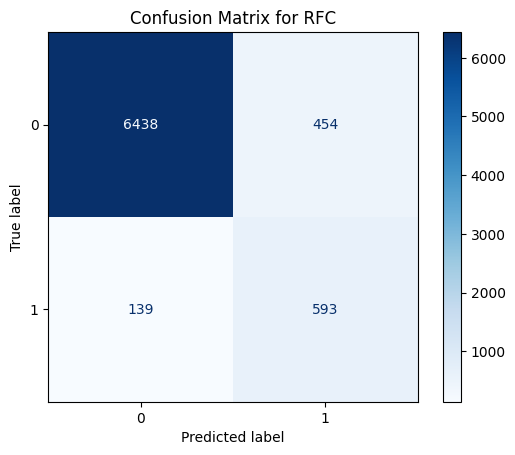

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Define your features and target.
features = ['NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
            'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug',
            'NetADC_NO2-NO2_ug','BCbb','BCff','BC6']

# Assume sensor_df_normalized and merged_df are already defined.
X = sensor_df_normalized[features].values
y = merged_df['burning'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
evaluate_model(y_pred, y_test, "RFC")



# GRU

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define your features and target.
features = ['NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
            'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug',
            'NetADC_NO2-NO2_ug','BCbb','BCff','BC6']

# Assume sensor_df_normalized and merged_df are already defined.
X = sensor_df_normalized[features].values
y = merged_df['burning'].values
ts = merged_df['timestamp(ZG)'].values

# Split data (using a simple train/test split).
X_train, X_test, y_train, y_test, ts_train, ts_test = train_test_split(
    X, y, ts,
    test_size=0.2,
    shuffle=False
)

# Reshape data for GRU input (samples, timesteps, features).
# Here we use a single timestep.
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build the GRU model.
model = Sequential([
    GRU(16, activation='tanh', return_sequences=False, 
        input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model.
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

# Predict probabilities on the test set.
y_pred_prob = model.predict(X_test)

Epoch 1/30


C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



983/983 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9090 - loss: 0.3381 - val_accuracy: 0.9070 - val_loss: 0.2006
Epoch 2/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9258 - loss: 0.1396 - val_accuracy: 0.9261 - val_loss: 0.1688
Epoch 3/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9366 - loss: 0.1119 - val_accuracy: 0.9179 - val_loss: 0.1671
Epoch 4/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9492 - loss: 0.1035 - val_accuracy: 0.8955 - val_loss: 0.1926
Epoch 5/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9534 - loss: 0.0950 - val_accuracy: 0.9049 - val_loss: 0.1791
Epoch 6/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9569 - loss: 0.0921 - val_accuracy: 0.9033 - val_loss: 0.1873
Epoch 7/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9591 - loss: 0.0863 - val_accuracy: 0.9047 - val_loss: 0.1870
Epoch 8/30
983/983 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9593 - loss: 0.0859 - val_accuracy: 0.9044 - val_

Best MCC: 0.5506 at Threshold: 0.25
Results for GRU:
MCC: 0.5506
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      7125
           1       0.40      0.92      0.56       732

    accuracy                           0.86      7857
   macro avg       0.70      0.89      0.74      7857
weighted avg       0.94      0.86      0.89      7857

Confusion Matrix:



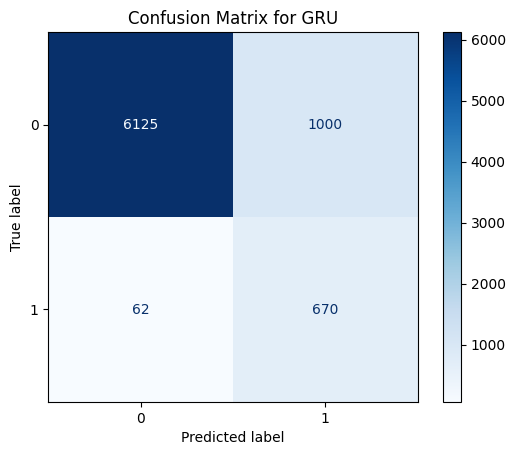

In [111]:
# IZGARANJE, REMOED LABELED DATA, REMOVED NULL BC VALUES:
# Best MCC: 0.7229 at Threshold: 0.45

best_mcc = -1  # MCC ranges from -1 to 1
best_threshold = 0

for threshold in np.arange(0.01, 0.9, 0.01):
    # Binarize the predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    mcc = matthews_corrcoef(y_test, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

y_pred_class = (y_pred_prob > best_threshold).astype(int)

print(f"Best MCC: {best_mcc:.4f} at Threshold: {best_threshold}")
evaluate_model(y_pred_class, y_test, "GRU")

In [90]:
import plotly.graph_objects as go
import pandas as pd

# # 1 – pretvori u 1D nizove
# ts_test_arr     = np.asarray(ts_test)
# y_test_arr      = y_test.flatten()
# y_pred_arr      = y_pred_class.flatten()

# # 2 – uzmi zajedničku minimalnu duljinu
# n = min(len(ts_test_arr), len(y_test_arr), len(y_pred_arr))

# # 3 – izreži
# ts_test_arr  = ts_test_arr[:n]
# y_test_arr   = y_test_arr[:n]
# y_pred_arr   = y_pred_arr[:n]

df_plot = pd.DataFrame({
    'timestamp': pd.to_datetime(ts_test),
    'Actual':    y_test.flatten(),
    'Predicted': y_pred_class.flatten()
})

fig = go.Figure()

# Stvarni podaci
fig.add_trace(go.Scatter(
    x=df_plot['timestamp'],
    y=df_plot['Actual'],
    mode='lines',
    name='Stvarno gorenje',
    line_shape='hv',
    connectgaps=False
))

# Predviđeni podaci
fig.add_trace(go.Scatter(
    x=df_plot['timestamp'],
    y=df_plot['Predicted'],
    mode='lines',
    name='Predviđeno gorenje',
    line=dict(dash='dot'),
    line_shape='hv',
    connectgaps=False
))

fig.update_layout(
    title="Stvarno vs. predviđeno gorenje",
    xaxis_title="Vrijeme",
    yaxis_title="Gorenje (0/1)",
    width=1200,
    height=600,
    xaxis=dict(
        rangeselector=dict(
            buttons=[
                dict(count=1, label="1 dan", step="day", stepmode="backward"),
                dict(step="all", label="Sve")
            ]
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

fig.show()

df_plot.to_csv("prediction.csv", index=False)


In [91]:
print("len(ts_test):      ", len(ts_test))
print("len(y_test):       ", len(y_test.flatten()))
print("len(y_pred_class): ", len(y_pred_class.flatten()))


len(ts_test):       7857
len(y_test):        7857
len(y_pred_class):  7857


# Permutation imporance with eli5

In [130]:
from sklearn.base import BaseEstimator

class GRUWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        # Since the model is already trained, we simply return self.
        return self

    def predict_proba(self, X):
        # Reshape from 2D (n_samples, n_features) to 3D (n_samples, 1, n_features)
        X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
        probs = self.model.predict(X_reshaped)
        # Squeeze to shape (n_samples,)
        probs = probs.squeeze()
        # Ensure it's 2D (n_samples, 1)
        if probs.ndim == 1:
            probs = probs.reshape(-1, 1)
        # Return probabilities for class 0 and class 1
        return np.hstack([1 - probs, probs])

    def predict(self, X, threshold=0.5):
        # Default prediction using the given threshold
        return (self.predict_proba(X)[:, 1] > threshold).astype(int)

    def score(self, X, y):
        """
        Searches for the best threshold that maximizes MCC on the provided data.
        """
        from sklearn.metrics import matthews_corrcoef

        y_pred_prob = self.predict_proba(X)[:, 1]
        best_mcc = -1  # MCC ranges from -1 to 1
        best_threshold = 0
        # Iterate over thresholds from 0.01 to 0.7 with a step of 0.001
        for threshold in np.arange(0.01, 0.7, 0.01):
            y_pred = (y_pred_prob > threshold).astype(int)
            mcc = matthews_corrcoef(y, y_pred)
            if mcc > best_mcc:
                best_mcc = mcc
                best_threshold = threshold
        print(f"Best threshold: {best_threshold}, Best MCC: {best_mcc}")
        return best_mcc

import eli5
from eli5.sklearn import PermutationImportance

X_test_2d = X_test.reshape(X_test.shape[0], X_test.shape[2])

# Wrap your trained model
wrapped_model = GRUWrapper(model)

# Set up permutation importance. You can adjust n_iter to average over several shuffles.
perm = PermutationImportance(wrapped_model, n_iter=10, random_state=42)

# Fit on the test set (using the original 2D version of X_test and y_test)
perm.fit(X_test_2d, y_test.ravel())

# Display the feature importances
eli5.show_weights(perm, feature_names=features)
#eli5.explain_weights(perm, feature_names=features)


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Best threshold: 0.25, Best MCC: 0.5505834826428149
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.02, Best MCC: 0.3954191882032584
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Best threshold: 0.53, Best MCC: 0.5185454953091365
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.54, Best MCC: 0.3319540116247017
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.51, Best MCC: 0.5517690598708526
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.21000000000000002, Best MCC: 0.5261872300692149
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.23, Best MCC: 0.5544556021867788
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.53, Best MCC: 0.5484781465393165
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.55, Best MCC: 0.21566479986366544
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best threshold: 0.06999999999999999, Best MCC: 0.5287103319259003
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best thr

Weight,Feature
0.3067 ± 0.0355,BCbb
0.2137 ± 0.0300,NetADC_CO-CO_ug
0.1628 ± 0.0196,NetCO2-CO2_ug
0.0300 ± 0.0147,NetADC_O3-O3_ug
0.0272 ± 0.0057,NetPM-PM25(µg/m3)
0.0195 ± 0.0118,BCff
0.0014 ± 0.0034,NetADC_NO2-NO2_ug
-0.0013 ± 0.0058,NetPid_P1-PPB_ug
-0.0101 ± 0.0142,NetPM-PM10(µg/m3)
-0.0115 ± 0.0067,BC6


# Permutation Importance

In [131]:
# Function to determine the best threshold based on MCC.
def best_mcc_threshold(y_true, y_pred_prob):
    best_mcc = -1  # MCC ranges from -1 to 1
    best_threshold = 0
    for threshold in np.arange(0.01, 0.99, 0.01):
        y_pred = (y_pred_prob > threshold).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
    return best_mcc, best_threshold

# Evaluate baseline performance.
baseline_mcc, baseline_threshold = best_mcc_threshold(y_test, y_pred_prob)
print(f"Baseline MCC: {baseline_mcc:.4f} at Threshold: {baseline_threshold}")

# Compute permutation importance using MCC.
results = []
results.append({'feature': 'BASELINE', 'mcc': baseline_mcc})

# Save a copy of the original test data.
X_test_original = X_test.copy()

# For each feature, permute its values and compute the new MCC.
for i in tqdm(range(X_test.shape[2]), desc="Computing permutation importance"):
    X_test_permuted = X_test_original.copy()
    # Shuffle the i-th feature column.
    np.random.shuffle(X_test_permuted[:, 0, i])
    
    # Get predictions with the permuted feature.
    y_pred_perm_prob = model.predict(X_test_permuted)
    
    # Compute the best MCC for the permuted data.
    perm_mcc, perm_threshold = best_mcc_threshold(y_test, y_pred_perm_prob)
    results.append({'feature': features[i], 'mcc': perm_mcc})

# Create a DataFrame with the results.
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='mcc', ascending=False)


Baseline MCC: 0.5506 at Threshold: 0.25


Computing permutation importance:   0%|          | 0/10 [00:00<?, ?it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  10%|█         | 1/10 [00:00<00:07,  1.21it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Computing permutation importance:  20%|██        | 2/10 [00:01<00:07,  1.08it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  30%|███       | 3/10 [00:02<00:06,  1.10it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Computing permutation importance:  40%|████      | 4/10 [00:03<00:05,  1.04it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Computing permutation importance:  50%|█████     | 5/10 [00:04<00:05,  1.00s/it]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  60%|██████    | 6/10 [00:05<00:04,  1.03s/it]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  70%|███████   | 7/10 [00:06<00:02,  1.06it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  80%|████████  | 8/10 [00:07<00:01,  1.09it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance:  90%|█████████ | 9/10 [00:08<00:00,  1.13it/s]

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Computing permutation importance: 100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


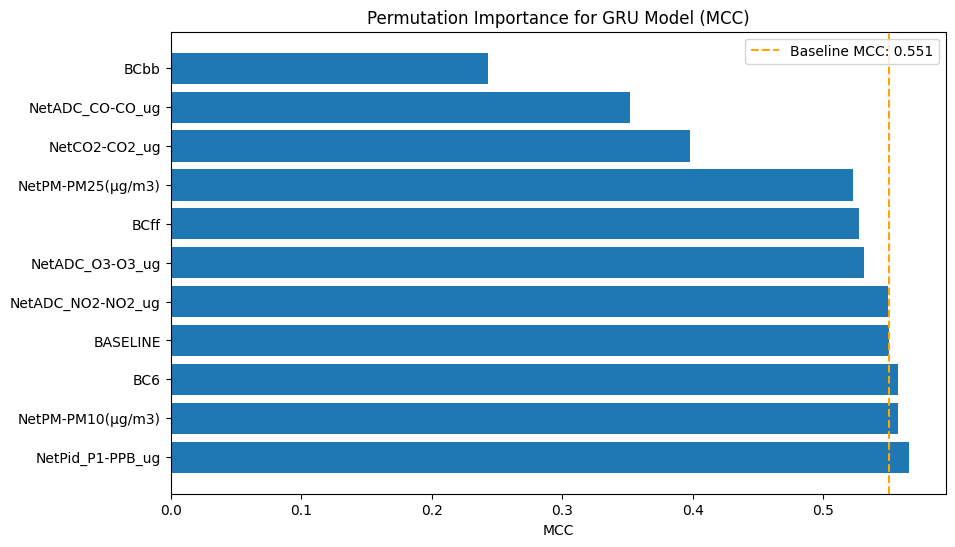

In [132]:

# Plot the permutation importance.
plt.figure(figsize=(10, 6))
plt.barh(df_results['feature'], df_results['mcc'])
plt.xlabel('MCC')
plt.title('Permutation Importance for GRU Model (MCC)')
plt.axvline(baseline_mcc, color='orange', linestyle='--', 
            label=f'Baseline MCC: {baseline_mcc:.3f}')
plt.legend()
plt.show()